# Image Quilting

The goal of this project is to implement the image quilting algorithm for texture synthesis and transfer,
described by [*Efros and Freeman (2001)](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/papers/efros-siggraph01.pdf).

Image quilting is a technique used in computer graphics and image processing to generate new images by
stitching together small patches of existing images. Image quilting works by dividing the input image into
overlapping patches, and then selecting a set of patches that closely match the target region to be filled in.
The selected patches are then stitched together in a way that minimizes visible seams and produces a coherent
output.

---

## Setup env

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

from typing import List, Tuple

from heapq import nsmallest


## Patch sample - algorithm comparison

### Randomly Sampled Texture
Image quilting with randomly sampled texture is a variation of the image quilting technique that involves
generating a new texture by randomly sampling patches from an input texture.

In [4]:
def _random(a):
    return random.randint(0, a)


def quilt_random(
    sample: np.ndarray, 
    out_size: int, 
    patch_size: int
) -> np.ndarray:
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: Sample image
    :param out_size: Output image size
    :param patch_size: Size of single patch 
    :return: Output texture
    """
    out_img = np.zeros((out_size, out_size, 3))
    sample_w, sample_h = sample.shape[:2]
    
    for i in range(0, out_size, patch_size):
        for j in range(0, out_size, patch_size):
            random_x, random_y = _random(sample_w-patch_size), _random(sample_h-patch_size)
            out_img[i:i+patch_size, j:j+patch_size, :] = np.copy(sample[random_x:random_x+patch_size, random_y:random_y+patch_size, :])
    return out_img.astype(np.uint8)

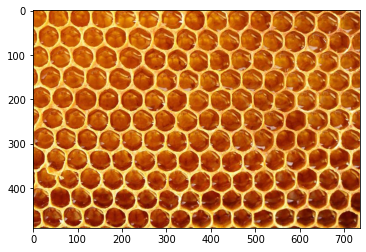

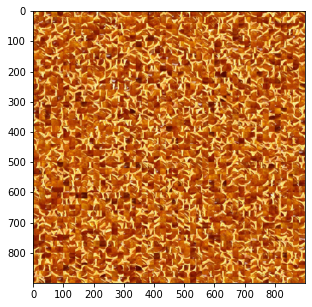

In [5]:
sample_img_fn = 'samples/honey.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 900
patch_size = 20 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

### Overlapping Patches
In this technique, the input image is divided into overlapping patches, and a set of patches is selected to fill
in the target region. The selected patches are then blended together along their overlapping edges to create a
seamless output.

In [6]:
def _ssd_patch(T: np.ndarray, M: np.ndarray, I: np.ndarray) -> np.ndarray:
    """
    Performes template matching with the overlapping region, computing the cost of sampling each patch, based on the sum of squared differences (SSD).

    :param T: Patch in the current output image that is to be filled in
    :param M: Mask of the overlapping region
    :param I: Sample image
    :return: SSD of the patch
    """
    T = T.astype(np.float64)
    M = M.astype(np.float64)
    I = I.astype(np.float64)
    
    def _ssd(ch: int):
        return ((M[:,:,ch]*T[:,:,ch])**2).sum() - 2 * cv2.filter2D(I[:,:,ch], ddepth=-1, kernel = M[:,:,ch]*T[:,:,ch]) + cv2.filter2D(I[:,:,ch] ** 2, ddepth=-1, kernel=M[:,:,ch])

    ssd_b = _ssd(0)
    ssd_g = _ssd(1)
    ssd_r = _ssd(2)

    return ssd_b + ssd_g + ssd_r


def _choose_sample(cost: np.ndarray, tol: int) -> np.ndarray:
    """
    Selects a randomly sampled patch with low cost.

    :param cost: Cost matrix
    :param tol: Tolerance
    :return: Patch with min cost
    """
    idx = np.argpartition(cost.ravel(), tol-1)[:tol]
    lowest_cost = np.column_stack(np.unravel_index(idx, cost.shape))
    return random.choice(lowest_cost)


def quilt_simple(
    sample: np.ndarray, 
    out_size: int, 
    patch_size: int, 
    overlap: int,
    tol: int
) -> np.ndarray:
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    
    :param sample: Sample image
    :param out_size: Output image size
    :param patch_size: Size of single patch 
    :param overlap: Size of the overlapping region
    :param tol: Tolerance
    :return: Output texture
    """
    sample_w, sample_h = sample.shape[:2]
    output = np.zeros((out_size, out_size, 3))
    
    offset = patch_size - overlap
    
    for i in range(0, out_size-offset, offset):
        for j in range(0, out_size-offset, offset):
            if i + j == 0:  # first patch
                output[i:i+patch_size, j:j+patch_size, :] = sample[0:patch_size, 0:patch_size, :]
                continue
            
            template = np.array(output[i:i+patch_size, j:j+patch_size, :], copy=True)
            mask = np.zeros((patch_size, patch_size, 3))
            
            if i == 0:
                mask[:, :overlap, :] = 1  # upper row mask
            elif j == 0:
                mask[:overlap, :, :] = 1  # left column mask
            else:
                mask[:, :overlap, :] = 1
                mask[:overlap, :, :] = 1
                
            half = patch_size // 2
                
            ssd = _ssd_patch(template, mask, sample)
            ssd = ssd[half:-half, half:-half]  # take only possible points
            x, y = _choose_sample(ssd, tol)
            
            output[i:i+patch_size, j:j+patch_size, :] = sample[x:x+patch_size, y:y+patch_size, :]
    return output.astype(np.uint8)

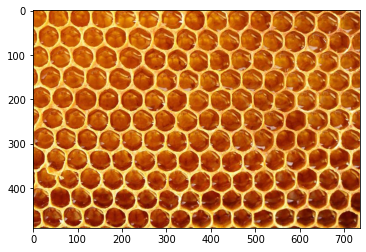

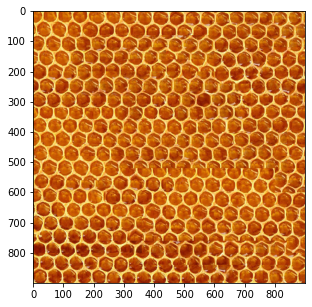

In [7]:
sample_img_fn = 'samples/honey.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 900 
patch_size = 60
overlap = 20
tol = 10
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

### Seam Finding
The goal of seam finding is to identify and remove visible seams between adjacent patches or images, and produce a seamless output that looks like it was created from a single image.

#### Custom cut algorithm

In [11]:
class Cell:
    def __init__(self, i: int, j: int, cost: np.ndarray, before):
        self.i, self.j = i, j
        self.cost = cost 
        self.before = before 
    @property
    def point(self) -> Tuple[int, int]:
        return (self.i, self.j)

class Grid:
    def __init__(self, n: int, m: int):
        self.n, self.m = n, m
        self.d = []
    def add(self, c: Cell) -> None:
        self.d.append(c)
    def get(self, i: int, j: int) -> List[Cell]:
        return [c for c in self.d if (c.i == i) and (c.j == j)][0]
    def get_col(self, j: int) -> List[Cell]:
        return self.d[self.n*j:self.n*2*j]
    
    
def customized_cut(err_patch: np.ndarray) -> [np.ndarray, List]:
    """
    Compute the minimum path frm the left to right side of the patch.
    
    :param err_patch: Cost of cutting through each pixel
    :return: A 0-1 mask that indicates which pixels should be on either side of the cut
    """
    h, w = err_patch.shape[:2]
    grid = Grid(h, w)
    
    #  fill first column
    for i in range(h):
        grid.add(Cell(i, 0, err_patch[i, 0], None))

    #  fill cost of each cell
    for j in range(1, w):
        for i in range(h):
            if i - 1 < 0:
                before = [grid.get(i, j-1), grid.get(i+1, j-1)]
            elif i + 1 >= h:
                before = [grid.get(i-1, j-1), grid.get(i, j-1)]
            else:
                before = [grid.get(i-1, j-1), grid.get(i, j-1), grid.get(i+1, j-1)]
            
            min_before = min(before, key=lambda x: x.cost)
            
            cell = Cell(i, j, err_patch[i, j] + min_before.cost, min_before)
            grid.add(cell)
    
    #  get last column
    last_column = grid.get_col(w-1)
    
    #  find best path
    cell = min(last_column, key=lambda x: x.cost)
    mask = np.zeros(err_patch.shape)
    best_path = []
    
    #  get best path
    for i in range(w, 0, -1):
        best_path.append(cell.point)
        x, y = cell.point
        mask[:x, y] = 1
        cell = cell.before
        
    return mask, best_path

#### Quilt cut

In [12]:
def _multiply_on_last_axis(matrix_a: np.ndarray, matrix_b: np.ndarray) -> np.ndarray:
    for i in range(matrix_a.shape[2]):
        matrix_a[:,:,i] *= matrix_b
    return matrix_a


def quilt_cut(
    sample: np.ndarray, 
    out_size: int, 
    patch_size: int, 
    overlap: int, 
    tol: int
) -> np.ndarray:
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    
    :param sample: Sample image
    :param out_size: Output image size
    :param patch_size: Size of single patch 
    :param overlap: Size of the overlapping region
    :param tol: Tolerance
    :return: Output texture
    """
    sample_w, sample_h = sample.shape[:2]
    output = np.zeros((out_size, out_size, 3))
    
    offset = patch_size - overlap
    
    for i in range(0, out_size-offset, offset):
        for j in range(0, out_size-offset, offset):
            if i + j == 0:  # first patch
                output[i:i+patch_size, j:j+patch_size, :] = sample[0:patch_size, 0:patch_size, :].copy()
                continue

            template = output[i:i+patch_size, j:j+patch_size, :].copy()
            
            mask = np.zeros((patch_size, patch_size, 3))
            if i == 0:
                mask[:, :overlap, :] = 1  # upper row mask
            elif j == 0:
                mask[:overlap, :, :] = 1  # left column mask
            else:
                mask[:, :overlap, :] = 1
                mask[:overlap, :, :] = 1
                
            half = patch_size // 2
                
            ssd = _ssd_patch(template, mask, sample)
            ssd = ssd[half:-half, half:-half]  # take only possible points
            x, y = _choose_sample(ssd, tol)
            
            patch = sample[x:x+patch_size, y:y+patch_size, :].copy()
            
            mask1 = np.zeros((patch_size, patch_size))
            diff1 = (template[:overlap, :patch_size, :] - patch[:overlap, :patch_size, :]) ** 2
            diff1 = np.sum(diff1, axis=2)
            mask_patch1, _ = customized_cut(diff1)
            mask1[:overlap, :patch_size] = mask_patch1
            
            mask2 = np.zeros((patch_size, patch_size))
            diff2 = (template[:patch_size, :overlap, :] - patch[:patch_size, :overlap, :]) ** 2
            diff2 = np.sum(diff2, axis=2)
            mask_patch2, _ = customized_cut(diff2.T)
            mask2[:patch_size, :overlap] = mask_patch2.T
            
            if j == 0:
                mask_cut = mask1
            elif i == 0:
                mask_cut = mask2
            else:
                mask_cut = np.logical_or(mask1, mask2)
            mask_cut = mask_cut.astype(np.uint8)
            
            template = _multiply_on_last_axis(template.copy(), mask_cut.copy())
                
            mask_cut ^= 1
            patch = _multiply_on_last_axis(patch.copy(), mask_cut.copy())
        
            output[i:i+patch_size, j:j+patch_size, :] = patch + template
    return output.astype(np.uint8)

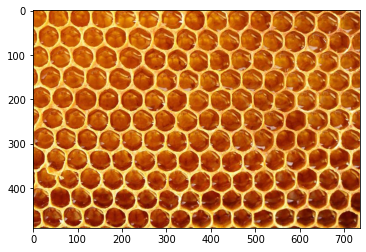

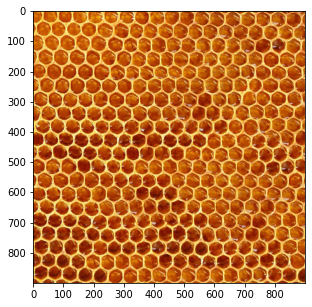

In [13]:
sample_img_fn = 'samples/honey.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 900
patch_size = 60
overlap = 20
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)

#### Visualization of seam finding algorithm

In [32]:
def display_overlap(
    sample: np.ndarray, 
    patch_size: int, 
    overlap: int, 
    tol: int
) -> None:
    """
    Displays the process of `quilt_cut` method.
    
    :param sample: Sample image
    :param patch_size: Size of single patch 
    :param overlap: Size of the overlapping region
    :param tol: Tolerance
    :return: None
    """
    mask = np.zeros((patch_size, patch_size, 3))
    mask[:overlap, :, :] = 1
    
    sample_h, sample_w = sample.shape[:2]
    random_x, random_y = _random(sample_h-patch_size), _random(sample_w-patch_size)
    
    template = sample[random_x:random_x+patch_size, random_y:random_y+patch_size, :].copy()
    template[overlap:, overlap:, :] = 0
    
    fig = plt.figure(figsize=(8, 18))
    
    ax = fig.add_subplot(5, 2, 1)
    ax.imshow(template.astype(np.uint8))
    ax.set_title('Next patch to be filled')

    half = patch_size // 2

    ssd = _ssd_patch(template, mask, sample)
    ssd = ssd[half:-half, half:-half]  
    x, y = _choose_sample(ssd, tol)
    
    patch = sample[x:x+patch_size, y:y+patch_size, :].copy()
    
    ax = fig.add_subplot(5, 2, 2)
    ax.imshow(patch.astype(np.uint8))
    ax.set_title('Best patch match')
                    
    mask1 = np.zeros((patch_size, patch_size))
    diff1 = (template[:overlap, :patch_size, :] - patch[:overlap, :patch_size, :]) ** 2
    diff1 = np.sum(diff1, axis=2)
    mask_patch1, path1 = customized_cut(diff1)
    mask1[:overlap, :patch_size] = mask_patch1
    
    ax = fig.add_subplot(5, 2, 3)
    ax.imshow(diff1.astype(np.uint8))
    ax.set_title('Horizontal cost')
    ax = fig.add_subplot(5, 2, 4)
    ax.imshow(mask1.astype(np.uint8), cmap='gray')
    ax.set_title('Horizontal seam')

    mask2 = np.zeros((patch_size, patch_size))
    diff2 = (template[:patch_size, :overlap, :] - patch[:patch_size, :overlap, :]) ** 2
    diff2 = np.sum(diff2, axis=2)
    mask_patch2, path2 = customized_cut(diff2.T)
    mask2[:patch_size, :overlap] = mask_patch2.T
    
    ax = fig.add_subplot(5, 2, 5)
    ax.imshow(diff2.astype(np.uint8))
    ax.set_title('Vertical cost')
    ax = fig.add_subplot(5, 2, 6)
    ax.imshow(mask2.astype(np.uint8), cmap='gray')
    ax.set_title('Vertical seam')

    mask_cut = np.logical_or(mask1.copy(), mask2.copy()).astype(np.uint8)
    
    ax = fig.add_subplot(5, 2, 7)
    ax.imshow(mask_cut.astype(np.uint8), cmap='gray')
    ax.set_title('Combined seam')
    
    template = _multiply_on_last_axis(template.copy(), mask_cut.copy())
    
    ax = fig.add_subplot(5, 2, 8)
    ax.imshow(template.astype(np.uint8), cmap='gray')
    ax.set_title('Old patch mask')
    
    mask_cut ^= 1
    patch = _multiply_on_last_axis(patch.copy(), mask_cut.copy())

    ax = fig.add_subplot(5, 2, 9)
    ax.imshow(patch.astype(np.uint8), cmap='gray')
    ax.set_title('New patch mask')
    
    ax = fig.add_subplot(5, 2, 10)
    ax.imshow((patch + template).astype(np.uint8), cmap='gray')
    ax.set_title('Filled patch')

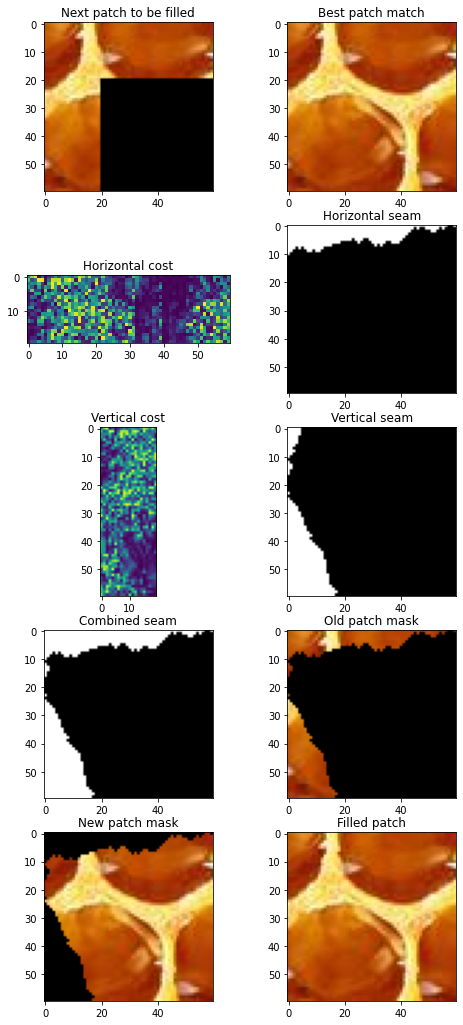

In [33]:
display_overlap(sample_img, 60, 20, 5)

## Texture Transfer
Texture transfer is a technique that involves transferring the texture of one image to another image, while preserving the structure and content of the target image. The goal of texture transfer is to create a new image that has the same visual appearance and texture as the source image, but with a different content.

The parameters used in texture transfer include:
- `Patch size`: The size of the patches used in the texture transfer. Smaller patches can capture more finegrained texture details, while larger patches can capture more global structure.
- `Overlap size`: The size of the overlapping regions.
- `Alpha`: Regularization factor employed to manage the balance between the replication of texture and the
accuracy of the match to the intended image correspondence map.
- `Tolerance`: Determines from how many lowest cost patches choose the target patch

In [36]:
def texture_transfer(
    sample: np.ndarray, 
    target: np.ndarray, 
    patch_size: int, 
    overlap: int, 
    tol: int, 
    alpha: float
) -> np.ndarray:
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    
    :param sample: Sample image
    :param patch_size: Size of single patch 
    :param overlap: Size of the overlapping region
    :param tol: Tolerance
    :param alpha: Strength of target
    :return: Output texture
    """
    target_w, target_h = target.shape[:2]
    output = np.zeros((target_w, target_h, 3))
    
    offset = patch_size - overlap                
    half = patch_size // 2
    
    for i in range(0, target_w-offset, offset):
        for j in range(0, target_h-offset, offset):
            template = output[i:i+patch_size, j:j+patch_size, :].copy()
            _target = target[i:i+patch_size, j:j+patch_size, :].copy()
            mask = np.zeros((patch_size, patch_size, 3))
            
            if template.shape[:2] != (patch_size, patch_size):
                continue
            
            if i == 0:
                mask[:, :overlap, :] = 1  # upper row mask
            elif j == 0:
                mask[:overlap, :, :] = 1  # left column mask
            else:
                mask[:, :overlap, :] = 1
                mask[:overlap, :, :] = 1

            ssd_overlap = _ssd_patch(template, mask, sample)
            ssd_target = _ssd_patch(_target, np.ones((patch_size, patch_size, 3)), sample)

            ssd_overlap = ssd_overlap[half:-half, half:-half]  
            ssd_target = ssd_target[half:-half, half:-half]  
            
            ssd = ssd_overlap * alpha + ssd_target * (1 - alpha)
            x, y = _choose_sample(ssd, tol)
            
            patch = sample[x:x+patch_size, y:y+patch_size, :].copy()
            
            mask1 = np.zeros((patch_size, patch_size))
            diff1 = (template[:overlap, :patch_size, :] - patch[:overlap, :patch_size, :]) ** 2
            diff1 = np.sum(diff1, axis=2)
            mask_patch1, _ = customized_cut(diff1)
            mask1[:overlap, :patch_size] = mask_patch1
            
            mask2 = np.zeros((patch_size, patch_size))
            diff2 = (template[:patch_size, :overlap, :] - patch[:patch_size, :overlap, :]) ** 2
            diff2 = np.sum(diff2, axis=2)
            mask_patch2, _ = customized_cut(diff2.T)
            mask2[:patch_size, :overlap] = mask_patch2.T
            
            if j == 0:
                mask_cut = mask1
            elif i == 0:
                mask_cut = mask2
            else:
                mask_cut = np.logical_or(mask1.copy(), mask2.copy())
            mask_cut = mask_cut.astype(np.uint8)
            
            template = _multiply_on_last_axis(template.copy(), mask_cut.copy())
                
            mask_cut ^= 1
            patch = _multiply_on_last_axis(patch.copy(), mask_cut.copy())
        
            output[i:i+patch_size, j:j+patch_size, :] = patch + template
    return output.astype(np.uint8)

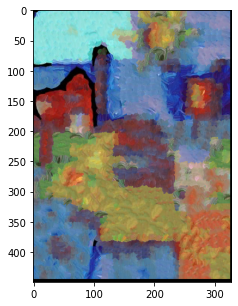

In [35]:
sample_img_fn = 'samples/texture_transfer7.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

sample_trg_fn = 'samples/texture_transfer2.jpg' 
sample_trg = cv2.cvtColor(cv2.imread(sample_trg_fn), cv2.COLOR_BGR2RGB)

patch_size = 15
overlap = 5
tol = 50
alpha = 0.75
res = texture_transfer(sample_img, sample_trg, patch_size, overlap, tol, alpha)

plt.figure(figsize=(5,5))
plt.imshow(res)

## Iterative texture transfer
Iterative texture transfer works by gradually refining the transfer of a texture from a source image to a target image through a series of iterations. It is often better than non-iterative approach because it allows for a gradual refinement of the texture transfer, resulting in better quality transfers and more accurate preservation of the source texture’s details and characteristics. By iteratively adjusting the transfer parameters, the algorithm can better capture the nuances and subtleties of the source texture, leading to a more natural and convincing transfer. Iterative approach is also more robust to variations in the source and target images. Since the transfer is optimized gradually, the algorithm can adapt to changes in the input images and adjust the transfer parameters accordingly. This can make the transfer more stable and less prone to artifacts and distortions.

In [37]:
def texture_transfer_iterative(
    sample: np.ndarray, 
    target: np.ndarray, 
    patch_size: int, 
    overlap: int, 
    tol: int, 
    iter_num: int, 
    reduction_factor: float
):
    """   
    :param sample: Sample image
    :param target: Target image
    :param patch_size: Size of single patch 
    :param overlap: Size of the overlapping region
    :param tol: Tolerance
    :param iter_num: Number of iterations
    :param reduction_factor: Reduction factor
    :return: Output texture
    """
    target_w, target_h = target.shape[:2]
    
    output = np.zeros((target_w, target_h, 3))
    
    for n in range(iter_num):
        synthesized_output = output.copy()
        output = np.zeros((target_w, target_h, 3))
        alpha = 0.1 + 0.8 * n / (iter_num - 1)
        offset = patch_size - overlap
        half = patch_size // 2
        
        for i in range(0, target_w-offset, offset):
            for j in range(0, target_h-offset, offset):
                template = output[i:i+patch_size, j:j+patch_size, :].copy()
                _target = target[i:i+patch_size, j:j+patch_size, :].copy()
                synthesized = synthesized_output[i:i+patch_size, j:j+patch_size, :].copy()
                
                mask = np.zeros((patch_size, patch_size, 3))

                if template.shape[:2] != (patch_size, patch_size):
                    continue

                if i == 0:
                    mask[:, :overlap, :] = 1  # upper row mask
                elif j == 0:
                    mask[:overlap, :, :] = 1  # left column mask
                else:
                    mask[:, :overlap, :] = 1
                    mask[:overlap, :, :] = 1

                ssd_overlap = _ssd_patch(template, mask, sample)
                ssd_overlap = ssd_overlap[half:-half, half:-half]  
                
                ssd_target = _ssd_patch(_target, np.ones((patch_size, patch_size, 3)), sample)
                ssd_target = ssd_target[half:-half, half:-half] 
                
                ssd_prev = 0
                if n > 0:  # n is number of iteration
                    ssd_prev = _ssd_patch(synthesized, np.ones((patch_size, patch_size, 3)), sample)
                    ssd_prev = ssd_prev[half:-half, half:-half] 
                
                ssd = (ssd_overlap + ssd_prev) * alpha + ssd_target * (1 - alpha)
                x, y = _choose_sample(ssd, tol)

                patch = sample[x:x+patch_size, y:y+patch_size, :].copy()

                mask1 = np.zeros((patch_size, patch_size))
                diff1 = (template[:overlap, :patch_size, :] - patch[:overlap, :patch_size, :]) ** 2
                diff1 = np.sum(diff1, axis=2)
                mask_patch1, _ = customized_cut(diff1)
                mask1[:overlap, :patch_size] = mask_patch1

                mask2 = np.zeros((patch_size, patch_size))
                diff2 = (template[:patch_size, :overlap, :] - patch[:patch_size, :overlap, :]) ** 2
                diff2 = np.sum(diff2, axis=2)
                mask_patch2, _ = customized_cut(diff2.T)
                mask2[:patch_size, :overlap] = mask_patch2.T

                if j == 0:
                    mask_cut = mask1.copy()
                elif i == 0:
                    mask_cut = mask2.copy()
                else:
                    mask_cut = np.logical_or(mask1.copy(), mask2.copy())
                mask_cut = mask_cut.astype(np.uint8)
            
                template = _multiply_on_last_axis(template.copy(), mask_cut.copy())

                mask_cut ^= 1
                patch = _multiply_on_last_axis(patch.copy(), mask_cut.copy())

                output[i:i+patch_size, j:j+patch_size, :] = patch + template
        patch_size = int(patch_size * reduction_factor)
        overlap = int(overlap * reduction_factor)
    return output.astype(np.uint8)

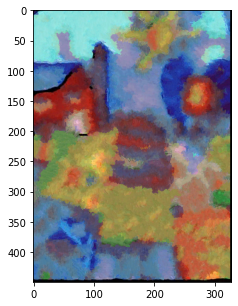

In [38]:
sample_img_fn = 'samples/texture_transfer7.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

sample_trg_fn = 'samples/texture_transfer2.jpg' 
sample_trg = cv2.cvtColor(cv2.imread(sample_trg_fn), cv2.COLOR_BGR2RGB)

patch_size = 20
overlap = 12
tol = 50
iter_num = 3
reduction = 0.7
res = texture_transfer_iterative(sample_img, sample_trg, patch_size, overlap, tol, iter_num, reduction)

plt.figure(figsize=(5,5))
plt.imshow(res)